In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Voice_Vertification

/content/drive/MyDrive/Voice_Vertification


# <b> <font color = 'cyan' size = '+3' > 1. Examine Speech Embedding

## 1.1 Torchaudio

In [ ]:
!pip install torchaudio

In [ ]:
TEST_ROOT = 'Zalo_Voice_Verification/Train-Test-Data/dataset/272-M-26/splitaudio'

In [ ]:
import glob 
import os 
import random

test_files = glob.glob(os.path.join(TEST_ROOT,'*.wav'))

In [ ]:
test_file = random.choice(test_files)
print(test_file)

Zalo_Voice_Verification/Train-Test-Data/dataset/272-M-26/splitaudio/20_chunk3.wav


In [ ]:
import torchaudio
import torchaudio.transforms as tf

test , sr = torchaudio.load(test_file)

In [ ]:
print(test.shape)

torch.Size([1, 72000])


In [ ]:
t1 = test.shape[1]/sr
print(t1)

1.5


In [ ]:
test = tf.Resample(sr,16000)(test)

In [ ]:
print(test.shape[1]/t1)

16000.0


In [ ]:
tf.MFCC(sample_rate =16000,n_mfcc=40)(test).shape

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


torch.Size([1, 40, 121])

In [ ]:
tf.MelSpectrogram(sample_rate =  16000, n_fft= 400)(test).shape

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


torch.Size([1, 128, 121])

In [ ]:
def get_melspec(file,sample_rate =  16000, n_fft= 400):
  test , sr = torchaudio.load(file)
  test = tf.Resample(sr,sample_rate)(test)
  test = tf.MelSpectrogram(sample_rate =  sample_rate, n_fft= n_fft)(test)
  if test.shape[0] !=1:
    test = test[0].unsqueeze(dim=0)
  return test

In [ ]:
get_melspec(test_file).shape

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


torch.Size([1, 128, 121])

## 1.2  ECAPA-TDNN embeddings on Voxceleb


In [ ]:
!pip install speechbrain

     |████████████████████████████████| 393 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 38.9 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 109 kB 59.6 MB/s 
     |████████████████████████████████| 636 kB 47.0 MB/s 
     |████████████████████████████████| 546 kB 47.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
test_file = random.choice(test_files)
print(test_file)

Zalo_Voice_Verification/Train-Test-Data/dataset/272-M-26/splitaudio/10_chunk0.wav


In [ ]:
from speechbrain.pretrained import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")
signal, fs = torchaudio.load(test_file)
embeddings = classifier.encode_batch(signal)
print(embeddings.shape)

Downloading:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129k [00:00<?, ?B/s]

torch.Size([1, 1, 192])


In [ ]:
from speechbrain.pretrained import SpeakerRecognition
other_test_audio = random.choice(test_files)
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb")
# score, prediction = verification.

In [ ]:
print(test_file)

Zalo_Voice_Verification/Train-Test-Data/dataset/272-M-26/splitaudio/10_chunk0.wav


## 1.3 HuggingFace

In [ ]:
!pip3 install transformers==4.9.2 soundfile datasets==1.11.0 pyctcdecode
!pip3 install https://github.com/kpu/kenlm/archive/master.zip

In [ ]:
from transformers.file_utils import cached_path, hf_bucket_url
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import os, zipfile
import torch

In [ ]:
cache_dir = './cache/'
processor = Wav2Vec2Processor.from_pretrained("nguyenvulebinh/wav2vec2-base-vietnamese-250h", cache_dir=cache_dir)
model = Wav2Vec2ForCTC.from_pretrained("nguyenvulebinh/wav2vec2-base-vietnamese-250h", cache_dir=cache_dir)
lm_file = hf_bucket_url("nguyenvulebinh/wav2vec2-base-vietnamese-250h", filename='vi_lm_4grams.bin.zip')
lm_file = cached_path(lm_file,cache_dir=cache_dir)
with zipfile.ZipFile(lm_file, 'r') as zip_ref:
    zip_ref.extractall(cache_dir)
lm_file = cache_dir + 'vi_lm_4grams.bin'

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
audio_file = 'Zalo_Voice_Verification/Train-Test-Data/dataset/426-F-48/426-13.wav'

In [ ]:
import librosa
signal, sr = librosa.load(audio_file,sr=16000)

In [ ]:
print(signal.shape)

(25030,)


In [ ]:
def map_to_array(batch):
    speech, sr = librosa.load(batch['file'],sr=16000)
    batch["speech"] = speech
    batch["sampling_rate"] = sr
    return batch

In [ ]:
# test thu
def get_embedding(wave_file):
  ds = map_to_array({"file": wave_file})

  input_values = processor(
        ds["speech"], 
        sampling_rate=ds["sampling_rate"], 
        return_tensors="pt"
  ).input_values
  logits = model(input_values).logits[0]
  return logits

print(get_embedding(audio_file).shape)

torch.Size([77, 110])


# <b> <font color = 'cyan' size = '+3' >  2.Data Exploration

In [ ]:
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
import random 
import glob

In [ ]:
DATA_ROOT = 'Zalo_Voice_Verification/Train-Test-Data/dataset'
subject_folders = os.listdir(DATA_ROOT)
print(len(subject_folders))
test_subject_folder =  os.path.join(DATA_ROOT, random.choice(subject_folders)) 

400


In [ ]:
test_audio_files = glob.glob(os.path.join(test_subject_folder,'*.wav'))

In [ ]:
test_audio_file = random.choice(test_audio_files)
ipd.Audio(test_audio_file)

In [ ]:
signal, sr = librosa.load(test_audio_file,sr=16000)

In [ ]:
print(len(signal)/sr)

0.8585


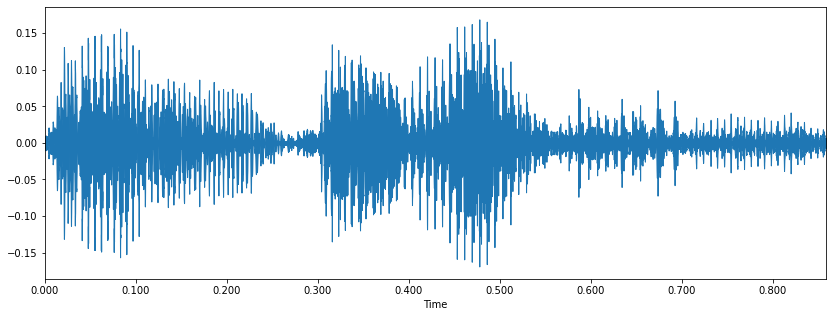

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(signal, sr)

In [ ]:
mfccs = librosa.feature.mfcc(signal, n_mfcc=13, sr=sr,n_fft=2048)
print(len(signal)/sr)
print(len(signal))
print(mfccs.shape)

0.8585
13736
(13, 27)


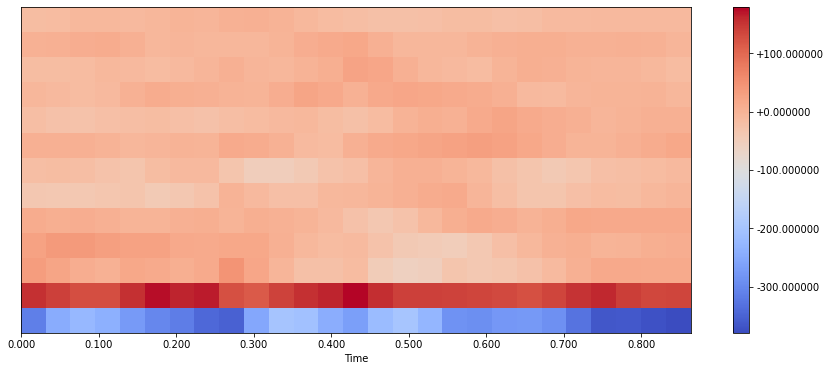

In [ ]:
plt.figure(figsize=(15,6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [ ]:
logits = get_embedding(test_audio_file)
print(logits.shape)

torch.Size([42, 110])


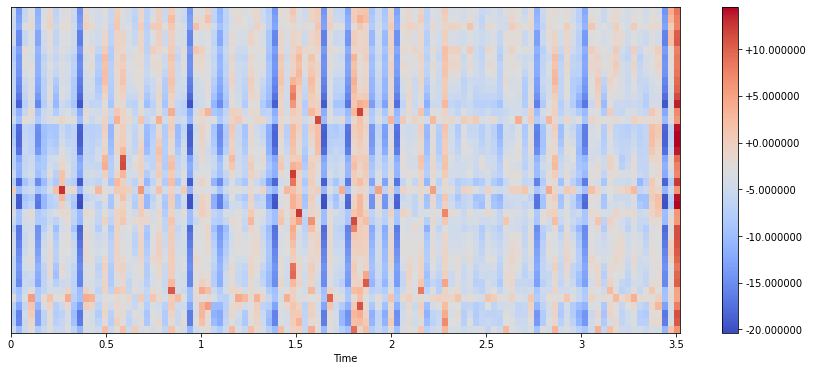

In [ ]:
plt.figure(figsize=(15,6))
librosa.display.specshow(logits.cpu().detach().numpy(), x_axis='time', sr=sr)
plt.colorbar(format="%+2f")
plt.show()

# <b> <font color = 'cyan' size = '+3' > 3.Dataset

##3.1 Wavaugment

In [ ]:
!apt-get install libsox-fmt-all libsox-dev sox > /dev/null
! python -m pip install torchaudio > /dev/null
! python -m pip install git+https://github.com/facebookresearch/WavAugment.git > /dev/null
!pip install ffmpeg-python > /dev/null

  Running command git clone -q https://github.com/facebookresearch/WavAugment.git /tmp/pip-req-build-d7sl60ty


In [ ]:
import augment

signal = torch.from_numpy(signal)

empty_chain = augment.EffectChain().clip(0.35)
clip_signal = empty_chain.apply(signal, src_info={'rate': sr})
reverb_signal = augment.EffectChain().reverb(50, 50, 50).channels(1).apply(signal, src_info={'rate': sr})
noise_generator = lambda: torch.zeros_like(signal).uniform_()
additive_noise_signal = augment.EffectChain().additive_noise(noise_generator, snr=20).apply(reverb_signal, src_info={'rate': sr})
time_dropout_signal =  augment.EffectChain().time_dropout(max_seconds=0.2).apply(additive_noise_signal, src_info={'rate': sr})

In [ ]:
ipd.Audio(signal, rate=sr)

In [ ]:
ipd.Audio(clip_signal, rate=sr)

In [ ]:
ipd.Audio(reverb_signal, rate=sr)

In [ ]:
ipd.Audio(additive_noise_signal, rate=sr)

In [ ]:
ipd.Audio(time_dropout_signal, rate=sr)

In [ ]:
def augment_wav(signal,sr=16000):
    signal = torch.from_numpy(signal)
    reverb_signal = augment.EffectChain().reverb(50, 50, 50).channels(1).apply(signal, src_info={'rate': sr})
    noise_generator = lambda: torch.zeros_like(reverb_signal).uniform_()
    additive_noise_signal = augment.EffectChain().additive_noise(noise_generator, snr=random.uniform(15,25)).apply(reverb_signal, src_info={'rate': sr})
    time_dropout_signal =  augment.EffectChain().time_dropout(max_seconds=random.uniform(0.1,0.25)).apply(additive_noise_signal, src_info={'rate': sr})
    return time_dropout_signal,sr

# djust this func for augmentation LOL
def map_to_array(batch,mode = 'train'):
    speech, sr = librosa.load(batch['file'],sr=16000)
    if mode == 'train':
      speech, sr = augment_wav(speech,sr)
      batch["speech"] = speech[0]
    else:
      batch["speech"] = speech
    batch["sampling_rate"] = sr
    return batch

def get_embedding(wave_file,mode = 'train'):
  ds = map_to_array({"file": wave_file},mode)

  input_values = processor(
        ds["speech"], 
        sampling_rate=ds["sampling_rate"], 
        return_tensors="pt"
  ).input_values
  logits = model(input_values).logits[0]
  return logits

def get_melspec(file,sample_rate =  16000, n_fft= 400,mode = 'train'):
  test , sr = torchaudio.load(file)
  test = tf.Resample(sr,sample_rate)(test)
  if mode == 'train':
    test, sr = augment_wav(test.numpy())
  test = tf.MelSpectrogram(sample_rate =  sr, n_fft= n_fft)(test)
  if test.shape[0] !=1:
    test = test[0].unsqueeze(dim=0)
  return test

In [ ]:
logits = get_embedding(test_audio_file,mode = 'train')
print(logits.shape)

torch.Size([42, 110])


## 3.2 Prepare & split data

In [ ]:
paths = glob.glob(DATA_ROOT+'/*/*.wav')

In [ ]:
print(len(paths))
print(paths[0])

10560
Zalo_Voice_Verification/Train-Test-Data/dataset/522-F-25/522-22.wav


In [ ]:
def get_prefix(file):
  split = file.split('/')
  return '/'.join(split[:-1]),split[-2]

In [ ]:
import json

def read_json(file):
  with open(file,'r') as f:
    data = json.load(f)
  return data

def write_json(file,data):
  with open(file,'w') as f:
    json.dump(data,f,indent = 4)

In [ ]:
def get_data(wave_paths=paths, save_emb=False, save_train_file = 'train_data.json', save_test_file = 'test_data.json', limit = 1000 , test_size = 0.2, subjects = np.array(subject_folders)):
    train_total = {}
    test_total = {}
    test_len = int(limit*test_size)
    train_len = limit - test_len
    check_exist = []

    for idx in tqdm(range(limit)):
      file1 = wave_paths[idx]
      predix, subject1= get_prefix(file1)
      label = random.choice([0,1]) 

      try: 
        if label == 1:
          wav_files = np.array(glob.glob(predix+'/*.wav'))
          other_wav_files = wav_files[wav_files!=file1]
          file2 = random.choice(other_wav_files)
        elif label == 0:
          other_folders = subjects[subjects!=subject1]
          predix_2 = predix.replace(subject1,random.choice(other_folders))
          file2 = random.choice(glob.glob(predix_2+'/*.wav'))

        if save_emb:

          if file1.endswith('wav') and file2.endswith('wav'):
            em1 = get_embedding(file1)
            em1 = torch.unsqueeze(em1,dim=0)
            em2 = get_embedding(file2)
            em2 = torch.unsqueeze(em2,dim=0)
            pair = file1+';'+file2+';'+str(label)
            check_exist_pair = set(pair.split(';'))

            if check_exist_pair not in check_exist:
              check_exist.append(check_exist_pair)
              if idx<=train_len:
                train_total[pair] = [em1.cpu().detach().tolist(),em2.cpu().detach().tolist()]
              else:
                test_total[pair] = [em1.cpu().detach().tolist(),em2.cpu().detach().tolist()]

        else:
          if file1.endswith('wav') and file2.endswith('wav'):
            pair = file1+';'+file2
            check_exist_pair = set([file1,file2])

            if check_exist_pair not in check_exist:
              check_exist.append(check_exist_pair)
              if idx<=train_len:
                train_total[pair] = int(label)
              else:
                test_total[pair] = int(label)
      except:
            continue
          

    write_json(save_train_file,train_total)
    write_json(save_test_file,test_total)



In [ ]:
get_data(limit=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

## 3.3 Custom Dataset

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class VoiceVerificationDataset(Dataset):
    def __init__(self, json_file, max_sequence_len = 118, resize = False, up_channel= False, mode = 'train'):
        super(VoiceVerificationDataset, self).__init__()
        self.data = list(read_json(json_file).items())
        self.max_sequence_len = max_sequence_len
        self.mode = mode
        self.up_channel = up_channel

    def preprocess(self, em):
        if self.up_channel:
          em = np.stack((em,)*3, axis=-1)
        if self.resize:
          em= cv2.resize(em,(224,224))
        return torch.from_numpy(em)

    def __getitem__(self, idx):
        pair, label = self.data[idx]
        pair = pair.split(';')
        
        file1,file2 = pair[0],pair[1]
        em1 = get_embedding(file1,self.mode).detach().numpy()
        em2 = get_embedding(file2,self.mode).detach().numpy()
 
        em1 = self.pad(em1)
        em1 = torch.from_numpy(em1.astype(np.float32))
        # em1 = torch.unsqueeze(em1,dim=0)
        em1 = self.preprocess(em1)
        # em1 = self.normalize(em1)

        em2 = self.pad(em2)
        em2 = torch.from_numpy(em2.astype(np.float32))
        # em2 = torch.unsqueeze(em2,dim=0)
        em2 = self.preprocess(em2)
        # em2 = self.normalize(em2)

        return em1, em2, torch.LongTensor([int(label)])

    def __len__(self):
        return len(self.data)
    
    def normalize(self,em):
        pass

    def pad(self,em):
        if em.shape[0] < self.max_sequence_len:
            pad = np.zeros((self.max_sequence_len - em.shape[0], em.shape[1]))
            em = np.concatenate((em, pad), axis=0)
        else:
            em = em[:self.max_sequence_len, :]
        assert em.shape == (self.max_sequence_len,110)
        return em

In [ ]:
class SpeechbrainDataset(Dataset):
    def __init__(self, json_file):
        super(SpeechbrainDataset, self).__init__()
        self.data = list(read_json(json_file).items())

    def __getitem__(self, idx):
        pair, label = self.data[idx]
        pair = pair.split(';')
        file1,file2 = pair[0],pair[1]

        em1 = self.get_embedding(file1)
        em2 = self.get_embedding(file2)

        return em1, em2, torch.LongTensor([int(label)])

    def __len__(self):
        return len(self.data)
    
    def get_embedding(self,file):
        signal, fs = torchaudio.load(file)
        embeddings = classifier.encode_batch(signal)
        
        assert embeddings.shape[-1] == 192
        if embeddings.shape[0] != 1:
            embeddings = torch.unsqueeze(embeddings[0],dim=0) # LOL
        return embeddings 

In [ ]:

class MelspecDataset(Dataset):
    def __init__(self, json_file, max_sequence_len = 128, resize = False, up_channel= False, mode = 'train'):
        super(MelspecDataset, self).__init__()
        self.data = list(read_json(json_file).items())
        self.max_sequence_len = max_sequence_len
        self.resize = resize
        self.mode = mode
        self.up_channel = up_channel

    def preprocess(self, em):
        if self.up_channel:
          em = np.stack((em,)*3, axis=-1)
        if self.resize:
          em= cv2.resize(em,(224,224))
        return torch.FloatTensor(em)

    def __getitem__(self, idx):
        pair, label = self.data[idx]
        pair = pair.split(';')
        
        file1,file2 = pair[0],pair[1]
        em1 = get_melspec(file1,mode = self.mode).detach().numpy()
        em2 = get_melspec(file2,mode = self.mode).detach().numpy()
 
        em1 = self.pad(em1)
        em1 = self.preprocess(em1)

        em2 = self.pad(em2)
        em2 = self.preprocess(em2)

        return self.normalize(em1), self.normalize(em2), torch.LongTensor([int(label)])

    def __len__(self):
        return len(self.data)
    
    def normalize(self,em,mean=0.5,std=0.5):
        # return (em - em.min())/(em.max()-em.min())
        return em

    def pad(self,em): # 1 128 X
        if em.shape[2] < self.max_sequence_len:
            pad = np.zeros((em.shape[0],em.shape[1],self.max_sequence_len - em.shape[2]))
            em = np.concatenate((em, pad), axis=2)
        else:
            em = em[:,:,:self.max_sequence_len]          
        assert em.shape == (1,128,self.max_sequence_len)
        return em

In [ ]:
pretrained_type = {0:'pretrained_Vietnamese',1:'pretrained_voxceleb',2:'no_pretrained-melspec'}
BATCH_SIZE = 64
NUM_WORKERS = 2

In [ ]:
def get_loader(type=1, bs = BATCH_SIZE, nw = NUM_WORKERS):
  print("GETTING {0} ...".format(pretrained_type[type]))
  
  if type==1:
    train_dataset = SpeechbrainDataset(json_file='train_data.json')
    test_dataset = SpeechbrainDataset(json_file='test_data.json')
  elif type == 0:
    train_dataset = VoiceVerificationDataset(json_file='train_data.json',up_channel=True, mode='train')
    test_dataset = VoiceVerificationDataset(json_file='test_data.json',up_channel=True, mode='val')
  else:
    train_dataset = MelspecDataset(json_file='train_data.json',up_channel=False, mode='train')
    test_dataset = MelspecDataset(json_file='test_data.json',up_channel=False, mode='val')

  train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS
  )

  test_loader = DataLoader(
          dataset=test_dataset,
          batch_size=BATCH_SIZE,
          num_workers=NUM_WORKERS
  )
  print("DONE!")
  return train_loader,test_loader

In [ ]:
train_loader,test_loader = get_loader(type=2)
print(len(test_loader))

GETTING no_pretrained-melspec ...
DONE!
31


# <b> <font color = 'cyan' size = '+3' > 4.Model

## 4.1 Siamese

In [ ]:
import torch.nn as nn  
import torch.nn.functional as F


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=.2),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.2),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=.2),
        )
        
        self.fc1 = nn.Linear(18432*2, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.reshape(output1.shape[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.reshape(output2.shape[0], -1)
        output = torch.hstack((output1,output2))
        output = nn.Dropout(0.2)(output)
        output = F.relu(self.fc1(output))
        output = nn.Dropout(0.1)(output)
        output = self.fc3(output)
        return output

In [ ]:
from torchsummary import summary

in1 = torch.randn((1,3,128,128))
in2 = torch.randn((1,3,128,128))

seamese_model = SiameseNetwork()
out = seamese_model(in1,in2)
summary(seamese_model, [(3, 128, 128),(3, 128, 128)],device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             448
              ReLU-2         [-1, 16, 126, 126]               0
       BatchNorm2d-3         [-1, 16, 126, 126]              32
         Dropout2d-4         [-1, 16, 126, 126]               0
         MaxPool2d-5           [-1, 16, 63, 63]               0
            Conv2d-6           [-1, 32, 61, 61]           4,640
              ReLU-7           [-1, 32, 61, 61]               0
       BatchNorm2d-8           [-1, 32, 61, 61]              64
         Dropout2d-9           [-1, 32, 61, 61]               0
        MaxPool2d-10           [-1, 32, 30, 30]               0
           Conv2d-11           [-1, 64, 28, 28]          18,496
             ReLU-12           [-1, 64, 28, 28]               0
      BatchNorm2d-13           [-1, 64, 28, 28]             128
        Dropout2d-14           [-1, 64,

## 4.2 Resnet + biLSTM

In [ ]:
import torch.nn as nn  
import torch.nn.functional as F
import torchvision.models as models


class SpeechModel(nn.Module):
    def __init__(self,dimension=256, hidden_dim = 512, out_dim=512):
        super(SpeechModel, self).__init__()
        self.fine_tune_resnet()

        self.lstm = nn.LSTM(input_size=2048,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True) 
        
        self.fc1 = nn.Linear(2*dimension, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.fc3 = nn.Linear(out_dim,1)

    def fine_tune_resnet(self):
        self.embeddings = models.resnet50(pretrained=False)
        self.embeddings = torch.nn.Sequential(*(list(self.embeddings.children())[:-1]))

    def forward(self, input):
        output = self.embeddings(input)
        output = nn.Dropout(0.4)(output)
        output = output.reshape(output.shape[0],-1,2048)
        output,_ = self.lstm(output)
        output = nn.Flatten()(output)
        output = F.relu(self.fc1(output))
        output = nn.Dropout(0.4)(output)
        output = F.relu(self.fc2(output))
        return output

In [ ]:
in1 = torch.randn((1,3,128,128))
speech_model = SpeechModel(1024)
out = speech_model(in1)
# summary(speech_model, (3, 110, 110),device = 'cpu')
print(out.shape)

torch.Size([1, 512])


## 4.3 Vggvox

In [ ]:
from collections import OrderedDict
from torchsummary import summary


class VGGVox(nn.Module):
    def __init__(self, n_classes=512):
        super(VGGVox, self).__init__()
        self.n_classes = n_classes
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=96, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))),
            ('bn1', nn.BatchNorm2d(96, momentum=0.5)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))),
            ('conv2', nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))),
            ('bn2', nn.BatchNorm2d(256, momentum=0.5)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))),
            ('conv3', nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
            ('bn3', nn.BatchNorm2d(384, momentum=0.5)),
            ('relu3', nn.ReLU()),
            ('conv4', nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
            ('bn4', nn.BatchNorm2d(256, momentum=0.5)),
            ('relu4', nn.ReLU()),
            ('conv5', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
            ('bn5', nn.BatchNorm2d(256, momentum=0.5)),
            ('relu5', nn.ReLU()),
            ('pool5', nn.MaxPool2d(kernel_size=(5, 3), stride=(3, 2))),
            ('fc6', nn.Conv2d(in_channels=256, out_channels=4096, kernel_size=(1, 2), stride=(1, 1))),
            ('bn6', nn.BatchNorm2d(4096, momentum=0.5)),
            ('relu6', nn.ReLU()),
            ('pool6', nn.AdaptiveAvgPool2d((1, 1))),
            ('flatten', nn.Flatten())]))

        self.classifier = nn.Sequential(OrderedDict([
            ('fc7', nn.Linear(4096, 1024)),
            ('relu7', nn.ReLU()),
            ('fc8', nn.Linear(1024, n_classes))]))

    def weight_init(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, input_tensor):
        output_tensor = self.features(input_tensor)
        output_tensor = self.classifier(output_tensor)
        return output_tensor

In [ ]:
in1 = torch.randn((2,1,128,128))
speech_model = VGGVox(n_classes=512)
# print(speech_model(in1).shape)
summary(speech_model, batch_size=2, input_size=(1,128, 128),device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [2, 96, 62, 62]           4,800
       BatchNorm2d-2            [2, 96, 62, 62]             192
              ReLU-3            [2, 96, 62, 62]               0
         MaxPool2d-4            [2, 96, 30, 30]               0
            Conv2d-5           [2, 256, 14, 14]         614,656
       BatchNorm2d-6           [2, 256, 14, 14]             512
              ReLU-7           [2, 256, 14, 14]               0
         MaxPool2d-8             [2, 256, 6, 6]               0
            Conv2d-9             [2, 384, 6, 6]         885,120
      BatchNorm2d-10             [2, 384, 6, 6]             768
             ReLU-11             [2, 384, 6, 6]               0
           Conv2d-12             [2, 256, 6, 6]         884,992
      BatchNorm2d-13             [2, 256, 6, 6]             512
             ReLU-14             [2, 25

## 4.4 Resnet-Based model

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_depth, depth, first=False):
        super(ResNetBlock, self).__init__()
        self.first = first
        self.conv1 = nn.Conv2d(in_depth, depth, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(depth)
        self.lrelu = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(depth, depth, kernel_size=3, stride=3, padding=1)
        self.conv11 = nn.Conv2d(in_depth, depth, kernel_size=3, stride=3, padding=1)
        if not self.first :
            self.pre_bn = nn.BatchNorm2d(in_depth)

    def forward(self, x):
        # x is (B x d_in x T)
        prev = x
        prev_mp =  self.conv11(x)
        if not self.first:
            out = self.pre_bn(x)
            out = self.lrelu(out)
        else:
            out = x
        out = self.conv1(x)
        # out is (B x depth x T/2)
        out = self.bn1(out)
        out = self.lrelu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        # out is (B x depth x T/2)
        out = out + prev_mp
        return out


class SpectrogramModel(nn.Module):
    def __init__(self):
        super(SpectrogramModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.block1 = ResNetBlock(32, 32,  True)
        self.mp = nn.MaxPool2d(3, stride=3, padding=1)
        self.block2 = ResNetBlock(32, 32,  False)
        self.block3 = ResNetBlock(32, 32,  False)
        self.block4= ResNetBlock(32, 32, False)
        self.block5= ResNetBlock(32, 32, False)
        self.block6 = ResNetBlock(32, 32, False)
        self.block7 = ResNetBlock(32, 32, False)
        self.block8 = ResNetBlock(32, 32, False)
        self.block9 = ResNetBlock(32, 32, False)
        self.block10 = ResNetBlock(32, 32, False)
        self.block11 = ResNetBlock(32, 32, False)
        self.lrelu = nn.LeakyReLU(0.01)
        self.bn = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.5)
      
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 512)
    
    def forward(self, x):
        batch_size = x.size(0)
        out = self.conv1(x)
        out = self.block1(out)
        #out = self.block2(out)
        #out = self.mp(out)
        out = self.block3(out)
        #out = self.block4(out)
        #out = self.mp(out)
        out = self.block5(out)
        #out = self.block6(out)
        #out = self.mp(out)
        out = self.block7(out)
        #out = self.block8(out)
        #out = self.mp(out)
        out = self.block9(out)
        #out = self.block10(out)
        #out = self.mp(out)
        out = self.block11(out)
        out = self.bn(out)
        out = self.lrelu(out)
        #out = self.mp(out)
        out = out.view(batch_size, -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.lrelu(out)
        out = self.fc2(out)
       
        return out

In [ ]:
in1 = torch.randn((2,1,128,128))
speech_model = SpectrogramModel()
out = speech_model(in1)
# summary(speech_model, (1, 128, 128),device = 'cpu')
print(out.shape)

torch.Size([2, 512])


In [ ]:
class Classifer(nn.Module):
    def __init__(self):
        super(Classifer, self).__init__()
        self.fc1 = nn.Linear(512*2, 16)
        self.fc2 = nn.Linear(16,2)
        self.logsoftmax = nn.LogSoftmax(dim=1)
    def forward(self, x1, x2):
        x = torch.hstack((x1,x2))
        x = self.fc1(x)
        x = self.fc2(x)
        # x = self.logsoftmax(x)
        return x

In [ ]:
classifier = Classifer()
out1 = classifier(out,out)
print(out1.shape)

torch.Size([2, 2])


# <b> <font color = 'cyan' size = '+3' > 5.Loss Function

## 5.1 TripletCenter

In [ ]:
from typing import Tuple
from torch import Tensor
from torch.autograd import Variable 


class TripletCenterLoss(nn.Module):
    def __init__(self, margin=1, num_classes=2):
        super(TripletCenterLoss, self).__init__() 
        self.margin = margin 
        self.ranking_loss = nn.MarginRankingLoss(margin=margin) 
        self.centers = nn.Parameter(torch.randn(num_classes, num_classes)) 
   
    def forward(self, inputs, targets): 
        batch_size = inputs.size(0) 
        targets_expand = targets.view(batch_size, 1).expand(batch_size, inputs.size(1)) 
        centers_batch = self.centers.gather(0, targets_expand) # centers batch 

        # compute pairwise distances between input features and corresponding centers 
        centers_batch_bz = torch.stack([centers_batch]*batch_size) 
        inputs_bz = torch.stack([inputs]*batch_size).transpose(0, 1) 
        dist = torch.sum((centers_batch_bz -inputs_bz)**2, 2).squeeze() 
        dist = dist.clamp(min=1e-12).sqrt() # for numerical stability 

        # for each anchor, find the hardest positive and negative 
        mask = targets.expand(batch_size, batch_size).eq(targets.expand(batch_size, batch_size).t())
        dist_ap, dist_an = [], [] 
        for i in range(batch_size): # for each sample, we compute distance 
            dist_ap.append(dist[i][mask[i]].max()) # mask[i]: positive samples of sample i
            dist_an.append(dist[i][mask[i]==0].min()) # mask[i]==0: negative samples of sample i 

        dist_ap = torch.stack(dist_ap)
        dist_an = torch.stack(dist_an)

        # generate a new label y
        # compute ranking hinge loss 
        y = dist_an.data.new() 
        y.resize_as_(dist_an.data)
        y.fill_(1)
        y = Variable(y)
        # y_i = 1, means dist_an > dist_ap + margin will casuse loss be zero 
        loss = self.ranking_loss(dist_an, dist_ap, y)

        prec = (dist_an.data > dist_ap.data).sum() * 1. / y.size(0) # normalize data by batch size 
        return loss, prec 

In [ ]:
# criterion = TripletCenterLoss()
# print(criterion(out,torch.LongTensor([[1],[0]])))

## 5.2 Contrastive

In [ ]:
from torch.nn import Module

class ContrastiveLoss(Module):
    def __init__(self, margin=3.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

# <b> <font color = 'cyan' size = '+3' > 6.EER- Metric



In [ ]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

def compute_eer(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    thresh = interp1d(fpr, thresholds)(eer)
    return eer, thresh

In [ ]:
def evaluate_pair(output1,output2,target,threshold):
    euclidean_distance = F.pairwise_distance(output1, output2)
    cond = euclidean_distance<threshold
    pos_sum = 0
    neg_sum = 0
    pos_acc = 0
    neg_acc = 0

    for i in range(len(cond)):
        if target[i]:
            neg_sum+=1
            if not cond[i]:
                neg_acc+=1
        if not target[i]:
            pos_sum+=1
            if cond[i]:
                pos_acc+=1

    return pos_acc,pos_sum,neg_acc,neg_sum

# <b> <font color = 'cyan' size = '+3' > 7.Train

In [ ]:
device = 'cuda'
EPOCH_N = 300
LEARNING_RATE = 0.0001
ckpt = 'resnet.pth'

In [ ]:
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter("ignore", UserWarning)
import cv2

In [ ]:

try:
  speech_model.load_state_dict(torch.load(ckpt))
except:
  pass

classifier = classifier.to(device)
speech_model = speech_model.to(device)
criterion1 = ContrastiveLoss().to(device)
criterion2 = nn.CrossEntropyLoss().to(device)
optimizer1 = torch.optim.SGD(classifier.parameters(), lr=LEARNING_RATE, momentum=0.9)
optimizer2 = torch.optim.Adam(speech_model.parameters(), lr=LEARNING_RATE)

BEST_LOSS = 9999
for epoch in range(EPOCH_N):
  train_loss_epoch = 0
  speech_model.train()
  train_acc_epoch = []

  for em1,em2,label in tqdm(train_loader):
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    em1 = em1.to(device)
    em2 = em2.to(device)
    label = label.to(device)
    out1 = speech_model(em1)
    out2 = speech_model(em2)
    loss1 = criterion1(out1,out2,label)
    out = classifier(out1,out2)
    loss2 = criterion2(out,label.squeeze(dim=1))

    loss = loss1*0.0+loss2*0.9
    train_loss_epoch+=loss.item()
    loss.backward()  
    optimizer1.step()
    optimizer2.step()
    _, predict = out.max(dim=1)
    train_acc_epoch.append(accuracy_score(predict.cpu().numpy(), label.cpu().numpy()))

  speech_model.eval()
  val_loss_epoch = 0
  val_acc_epoch = []

  with torch.no_grad():
    for em1,em2,label in tqdm(test_loader):
      em1 = em1.to(device)
      em2 = em2.to(device)
      label = label.to(device)
      out1 = speech_model(em1)
      out2 = speech_model(em2)
      loss1 = criterion1(out1,out2,label)
      out = classifier(out1,out2)
      loss2 = criterion2(out,label.squeeze(dim=1))
      loss = loss1*0.0 + loss2*0.9
      val_loss_epoch+=loss.item()
      _, predict = out.max(dim=1)
      val_acc_epoch.append(accuracy_score(predict.cpu().numpy(), label.cpu().numpy()))

  if val_loss_epoch < BEST_LOSS:
    BEST_LOSS = val_loss_epoch
    torch.save(speech_model.state_dict(),ckpt)
  torch.save(speech_model.state_dict(),'current_model.pth')

  print("EPOCH: ", epoch+1,"--->", train_loss_epoch,"train_ACC: ",sum(train_acc_epoch)/len(train_acc_epoch), "--->", val_loss_epoch, "--->val_ACC: ", sum(val_acc_epoch)/len(val_acc_epoch))


# <b> <font color = 'cyan' size = '+3' > 8.Test

In [ ]:
SAVE_FILE = 'result.txt'

speech_model = VGGVox(n_classes=512).to(device)

try:
  speech_model.load_state_dict(torch.load(ckpt))
except:
  pass

speech_model.eval()

In [ ]:
# !wget https://github.com/bml1g12/zalo-2020-challenge-voice-verification/blob/master/submissions/3/Public-test.csv

In [ ]:
import pandas as pd

labels = 'Public-test.csv'
labels = pd.read_csv(labels)
labels = labels['label']

In [ ]:
public_test = 'Zalo_Voice_Verification/Train-Test-Data/public-test.csv'
test_files = pd.read_csv(public_test)
test_wave_folder = 'Zalo_Voice_Verification/Train-Test-Data/public-test'

test_files['audio_1'] = test_files['audio_1'].apply(lambda x: os.path.join(test_wave_folder, x))
test_files['audio_2'] = test_files['audio_2'].apply(lambda x: os.path.join(test_wave_folder, x))

In [ ]:
def get_label(file1 ,file2,seamese_model = speech_model,max_sequence_len=128,mode = 'val', up_channel = False, resize = False):

    def pad(em):
        if em.shape[0] < max_sequence_len:
            pad = np.zeros((max_sequence_len - em.shape[0], em.shape[1]))
            em = np.concatenate((em, pad), axis=0)
        else:
            em = em[:max_sequence_len, :]
        assert em.shape == (max_sequence_len,128)
        return em

    def preprocess(em, up_channel = up_channel):
        if up_channel:
          em = np.stack((em,)*3, axis=-1)
        if resize:
          em= cv2.resize(em,(224,224))
        return torch.from_numpy(em)

    em1 = get_embedding(file1,mode).detach().numpy()
    em2 = get_embedding(file2,mode).detach().numpy()

    em1 = preprocess(em1)
    em2 = preprocess(em2)
  
    em1 = torch.unsqueeze(em1,dim=0).permute(0,3,2,1)
    em2 = torch.unsqueeze(em2,dim=0).permute(0,3,2,1)

    out1 = seamese_model(em1.to(device))
    out2 = seamese_model(em2.to(device))

    predict = F.pairwise_distance(out1, out2, keepdim=True) 
    predict[predict>=0.5] = 1
    predict[predict<0.5] = 0

    return predict    

In [ ]:
# for pretrained voxceleb
# def get_label(file1 ,file2,seamese_model = speech_model):
#     def get_embedding(file):
#         signal, fs = torchaudio.load(file)
#         embeddings = classifier.encode_batch(signal)
        
#         assert embeddings.shape[-1] == 192
#         if embeddings.shape[0] != 1:
#             embeddings = torch.unsqueeze(embeddings[0],dim=0) # LOL
#         return embeddings 

#     em1 = get_embedding(file1)
#     em1 = torch.unsqueeze(em1,dim=0)
#     em2 = get_embedding(file2)
#     em2 = torch.unsqueeze(em2,dim=0)

#     out1 = seamese_model(em1.to(device))
#     out2 = seamese_model(em2.to(device))

#     predict = F.pairwise_distance(out1, out2, keepdim=True) 
#     predict[predict>=0.5] = 1
#     predict[predict<0.5] = 0

#     return predict 

In [ ]:
results = []
with open(SAVE_FILE,'w') as f:
  with torch.no_grad():
    for i,(file1,file2) in enumerate(tqdm(zip(test_files['audio_1'].to_numpy(),test_files['audio_2'].to_numpy()))):
      predict = get_label(file1,file2)
      results.append(predict.cpu().numpy()[0])
      f.write(file1.split('/')[-1] +','+ file2.split('/')[-1] +','+ str(predict) + ' \n')

In [ ]:
accuracy_score(labels[:len(results)],results)

In [ ]:
# @title backup

try:
  speech_model.load_state_dict(torch.load(ckpt))
except:
  pass

speech_model = speech_model.to(device)
criterion1 = ContrastiveLoss().to(device)
weight = torch.FloatTensor([1.0, 9.0]).to(device)
criterion2 = nn.NLLLoss(weight=weight)
# optimizer = torch.optim.SGD(speech_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
optimizer = torch.optim.Adam(speech_model.parameters(), lr=LEARNING_RATE)

BEST_LOSS = 9999
for epoch in range(EPOCH_N):
  train_loss_epoch = 0
  speech_model.train()
  train_acc_epoch = []

  train_pos_accuracy = 0
  train_neg_accuracy = 0
  train_num_pos = 0
  train_num_neg = 0

  for em1,em2,label in tqdm(train_loader):
    optimizer.zero_grad()
    em1 = em1.to(device)
    em2 = em2.to(device)
    label = label.to(device)
    out1 = speech_model(em1)
    out2 = speech_model(em2)
    loss= criterion(out1,out2,label)
    train_loss_epoch+=loss.item()
    loss.backward()  
    optimizer.step()
    pos_acc,pos_sum,neg_acc,neg_sum = evaluate_pair(out1,out2,label,threshold=0.3)
    train_pos_accuracy+=pos_acc
    train_neg_accuracy+=neg_acc
    train_num_pos+=pos_sum
    train_num_neg+=neg_sum

  speech_model.eval()
  val_loss_epoch = 0
  val_acc_epoch = []
  val_pos_accuracy = 0
  val_neg_accuracy = 0
  val_num_pos = 0
  val_num_neg = 0
  with torch.no_grad():
    for em1,em2,label in tqdm(test_loader):
      em1 = em1.to(device)
      em2 = em2.to(device)
      label = label.to(device)
      out1 = speech_model(em1)
      out2 = speech_model(em2)
      loss= criterion(out1,out2,label)
      val_loss_epoch+=loss.item()
      pos_acc,pos_sum,neg_acc,neg_sum = evaluate_pair(out1,out2,label,threshold=0.3)
      val_pos_accuracy+=pos_acc
      val_neg_accuracy+=neg_acc
      val_num_pos+=pos_sum
      val_num_neg+=neg_sum

  if val_loss_epoch < BEST_LOSS:
    BEST_LOSS = val_loss_epoch
    torch.save(speech_model.state_dict(),ckpt)
  torch.save(speech_model.state_dict(),'vggvox_ex2_current_model.pth')
  
  mean_train_acc = train_neg_accuracy / train_num_neg + train_pos_accuracy / train_num_pos
  mean_val_acc = val_neg_accuracy / val_num_neg + val_pos_accuracy / val_num_pos
  print("EPOCH: ", epoch+1,"--->", train_loss_epoch,"train_ACC: ",mean_train_acc/2, "--->", val_loss_epoch, "--->val_ACC: ", mean_val_acc/2)